In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"; # for GPU 1.

import pandas as pd
import numpy as np
import os
import librosa 
import matplotlib.pyplot as plt
from multiprocessing import  Pool
from functools import partial
import numpy as np
import pickle

# https://towardsdatascience.com/urban-sound-classification-part-1-99137c6335f9

def path_class(filename):
    d = data[data['slice_file_name']==filename]
    path_name = os.path.join('data','UrbanSound8K','audio','fold'+str(d.fold.values[0]), filename)
    return path_name, d['class'].values[0]

def wave_plotter():
    
    return 

def printWave(pn):
    aWave =  librosa.core.load(pn)
    # plt.plot(aWave)
    print(aWave, type(aWave),aWave[0].shape)
    
def checkWave(pn):
    ok=True
    try:
        aWave =  librosa.core.load(pn)
    except TypeError as error:
        print(error)
        ok=False
        
    return ok


def loadWave(pn):
    ok=True
    try:
        aWave =  librosa.core.load(pn)
    except TypeError as error:
        print(error)
        ok=False
        
    return aWave

def parallelize(data, func, num_of_processes=3):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

In [2]:
def loadWaveRow(x):
    return loadWave(path_class(x['slice_file_name'])[0])

In [3]:
f=open('data.pk','rb')
data = pickle.load(f)
f.close()

In [4]:
import pywt
##### Perform wavelet decomposition on your generated data
def removeNoise(signal_noise):
    signal_noise=signal_noise['rawWave'][0]
    waveletname_q1 = 'haar'
    waveletlevel_q1 = 4

    # Step 1: Perform wavelet decomposition
    coeffs_orig_q1 = pywt.wavedec(signal_noise, waveletname_q1, level=waveletlevel_q1)
    coeffs_filter_q1 = coeffs_orig_q1.copy()

    # Step 2: Perform thresholding on the wavelet coefficients
    # Set the threshold
    threshold_q1 = 0.7

    for i in range(1, len(coeffs_orig_q1)):
        coeffs_filter_q1[i] = pywt.threshold(coeffs_orig_q1[i], threshold_q1*max(coeffs_orig_q1[i]))

    # Step 3: Perform reconstruction on the filered coefficients
    signal_denoised_q1 = pywt.waverec(coeffs_filter_q1, waveletname_q1)
    return signal_denoised_q1

In [5]:
# data['denoiseWave'] = data['rawWave'].apply(removeNoise)
data['denoiseWave']=parallelize(data, partial(run_on_subset, removeNoise), 7)

[ 0.00022074  0.00022074  0.00022074 ... -0.00126943 -0.00126943
 -0.00126943]


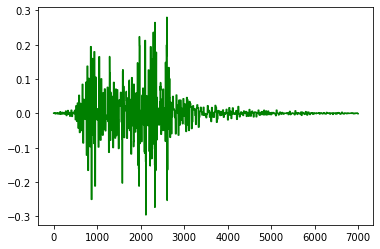

In [6]:
def plotDenoise(fileName):
    index = data.loc[data['slice_file_name']==fileName].index.values
    ampls = data['denoiseWave'][index]
    print(ampls[0])
    plt.plot(ampls[0].T,'g')
    plt.show()
plotDenoise('100032-3-0-0.wav')

(array([-0.00346022, -0.00502555, -0.00465325, ..., -0.00248061,
       -0.00155105, -0.0003528 ], dtype=float32), 22050)


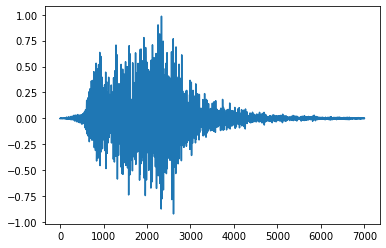

In [7]:
def plotRawwave(fileName):
    index = data.loc[data['slice_file_name']==fileName].index.values
    ampls = data['rawWave'][index]
    print(ampls[0])
    plt.plot(ampls[0][0].T)
    plt.show()
plotRawwave('100032-3-0-0.wav')

In [8]:
from scipy.io import wavfile as wav
import struct
import IPython.display as ipd
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('data/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  0.31755102040816324  second
number of samples:  14004
class:  dog_bark


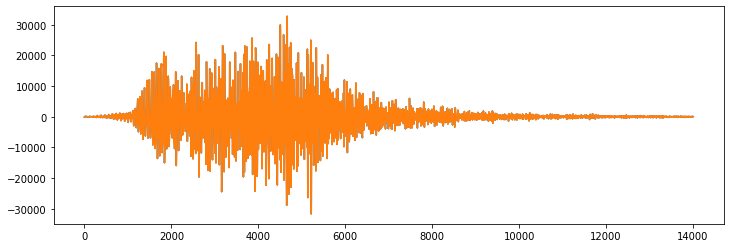

In [9]:
fullpath, label = path_class('100032-3-0-0.wav')
wav_plotter(fullpath,label)

In [10]:
maxLength = 0
for wav in data['rawWave']:
    if len(wav[0]) > maxLength:
        maxLength = len(wav[0])
print(maxLength)

89009


In [11]:
def resizeToMax(row):
#     print(row[0])
    
    sampleWave = row
    unit = np.zeros(maxLength)
    while len(sampleWave)<maxLength:
        sampleWave=np.append(sampleWave,unit)
        
    return sampleWave[:maxLength]

data['resizeDenoise']=data['denoiseWave'].apply(resizeToMax)

In [17]:
data = data.drop(['denoiseWave', 'rawWave'], axis=1)
data.head

<bound method NDFrame.head of          slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  \
0           3         

In [18]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(
         data, test_size=0.1, random_state=42)
train, valid = train_test_split(
         train_val, test_size=0.2, random_state=42)

In [19]:
f = open('dataTrain_2.pk', 'wb')
pickle.dump(train, f)
f.close()

In [20]:
f = open('dataValid_2.pk', 'wb')
pickle.dump(valid, f)
f.close()

In [21]:
f = open('dataTest_2.pk', 'wb')
pickle.dump(test, f)
f.close()

In [22]:
train.shape

(6286, 9)

In [23]:
valid.shape

(1572, 9)

In [24]:
test.shape

(874, 9)

In [25]:
train.head

<bound method NDFrame.head of         slice_file_name    fsID       start         end  salience  fold  \
4578    18594-1-6-0.wav   18594   77.175828   77.611488         1     3   
328   104998-7-16-5.wav  104998  424.655994  428.655994         1     5   
1077  124489-9-0-18.wav  124489    9.000000   13.000000         1     1   
1951  147491-9-2-10.wav  147491   96.062031  100.062031         2    10   
3475  171305-7-19-0.wav  171305   81.030035   82.575304         1     4   
...                 ...     ...         ...         ...       ...   ...   
6350    39884-5-0-6.wav   39884   11.085243   15.085243         1     6   
5922    27070-2-0-4.wav   27070    2.000000    6.000000         2    10   
1550  137969-2-0-18.wav  137969    9.000000   13.000000         1     6   
5600   22601-8-0-20.wav   22601   10.000000   14.000000         2     3   
7409    71171-4-0-4.wav   71171    2.813427    6.813427         1     5   

      classID             class  \
4578        1          car_horn   

In [26]:
train = None
valid = None
test = None
data = None